In [7]:
import pandas as pd
import numpy as np

In [8]:
import sklearn as sk
import json

In [9]:
# Checking the test dataset

In [10]:
from pandas.io.json import json_normalize
import time
from datetime import datetime
import gc
import psutil
from sklearn.preprocessing import LabelEncoder

In [11]:
columns_to_parse = ['device','geoNetwork','totals','trafficSource']

In [12]:
def parse_dataframe(path):
    #path = '/Users/abhayranjan/kaggle/google/all/train.csv'
    data_df= pd.read_csv(path,converters={column: json.loads for column in columns_to_parse},
                                dtype={'fullVisitorId':str})
    
    #parse the json type columns
    for col in columns_to_parse:
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
        # we drop the object column processed and we add the column created from json fields.
        data_df = data_df.drop(col,axis=1).merge(json_col_df,right_index=True,left_index=True)
        
    return data_df 

In [13]:
def process_datetime(data_df):
    data_df['date'] = data_df['date'].astype(str)
    data_df['date'] = data_df['date'].apply(lambda x:x[:4]+"-"+x[4:6]+"-"+x[6:])
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df['year'] = data_df['date'].dt.year
    data_df['month'] = data_df['date'].dt.month
    data_df['day'] = data_df['date'].dt.day
    data_df['weekday'] =data_df['date'].dt.weekday
    data_df['weekofyear'] =data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    return data_df

In [14]:
def process_format(data_df):
    print("Inside process_format function")
    for col in ['visitNumber','totals_hits','totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
            
    data_df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True,inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna('False',inplace=True)
    return data_df

In [15]:
def process_device(data_df):
    print("process device")
    data_df['browser_category'] = data_df['device_browser'] + "_"+data_df['device_deviceCategory']
    data_df['browser_os'] = data_df['device_browser'] + "_"+data_df['device_operatingSystem']
    return data_df


In [16]:
def process_totals(data_df):
    print("process totals..")
    data_df['visitNumber'] = np.log1p(data_df['visitNumber'])
    data_df['totals_hits'] = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews'] = np.log1p(data_df['totals_pageviews']).fillna(0)
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('max')
    data_df['min_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('min')
    data_df['var_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('var')
    data_df['mean_pageviews_per_day'] = data_df.groupby(['day'])['totals_pageviews'].transform('mean')
    data_df['sum_pageviews_per_day'] = data_df.groupby(['day'])['totals_pageviews'].transform('sum')
    data_df['max_pageviews_per_day'] = data_df.groupby(['day'])['totals_pageviews'].transform('max')
    data_df['min_pageviews_per_day'] = data_df.groupby(['day'])['totals_pageviews'].transform('min')
    return data_df

In [17]:
def process_geo_network(data_df):
    print("process geo network...")
    data_df['sum_pageviews_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_pageviews'].transform('count') 
    data_df['mean_pageviews_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain'] = data_df.groupby(['geoNetwork_networkDomain'])['totals_hits'].transform('mean')
    return data_df                                                  

In [18]:
#g_train_df = process_geo_network(g_train_df)

columns_to_parse = ['device','geoNetwork','totals','trafficSource']


In [19]:
pd.set_option('display.max.columns',None)

In [20]:
#g_train_df.head(n=5)

In [21]:
def process_traffic_source(data_df):
    print("process traffic source....")
    data_df['source_country'] = data_df['trafficSource_source']+"_" +data_df['geoNetwork_country']
    data_df['campaign_medium'] = data_df['trafficSource_campaign']+"_" +data_df['trafficSource_medium']
    data_df['medium_hits_mean'] = data_df.groupby(['trafficSource_medium'])['totals_hits'].transform('mean')
    data_df['medium_hits_min'] = data_df.groupby(['trafficSource_medium'])['totals_hits'].transform('min')
    data_df['medium_hits_max'] =data_df.groupby(['trafficSource_medium'])['totals_hits'].transform('max')
    data_df['medium_hits_sum'] = data_df.groupby(['trafficSource_medium'])['totals_hits'].transform('sum')
    return data_df

In [22]:
g_train_df = parse_dataframe('/Users/abhayranjan/kaggle/google/all/train.csv')
g_train_df = process_datetime(g_train_df)                                                  

In [23]:
g_test_df = parse_dataframe('/Users/abhayranjan/kaggle/google/all/test.csv')
g_test_df = process_datetime(g_test_df)   

In [24]:
cols_to_drop = [col for col in g_train_df.columns if g_train_df[col].nunique(dropna=False) == 1]
g_train_df.drop(cols_to_drop, axis=1, inplace=True)
g_test_df.drop([col for col in cols_to_drop if col in g_test_df.columns], axis=1, inplace=True)

###only one not null value
g_train_df.drop(['trafficSource_campaignCode'], axis=1, inplace=True)

###converting columns format
g_train_df['totals_transactionRevenue'] = g_train_df['totals_transactionRevenue'].astype(float)
g_train_df['totals_transactionRevenue'] = g_train_df['totals_transactionRevenue'].fillna(0)

In [25]:
g_train_df = process_format(g_train_df)
g_tain_df = process_device(g_train_df)
g_train_df = process_totals(g_train_df)
g_train_df = process_geo_network(g_train_df)
g_train_df = process_traffic_source(g_train_df)   

Inside process_format function
process device
process totals..


/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


process geo network...
process traffic source....


In [26]:
g_test_df = process_format(g_test_df)
g_test_df = process_device(g_test_df)
g_test_df = process_totals(g_test_df)
g_test_df = process_geo_network(g_test_df)
g_test_df = process_traffic_source(g_test_df)   

Inside process_format function
process device
process totals..


/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


process geo network...
process traffic source....


In [27]:
# Numeric Columns

num_cols = ['month_unique_user_count','day_unique_user_count','weekday_unique_user_count','visitNumber','total_hits','total_pageviews','mean_hits_per_day','sum_hits_per_day','max_hits_per_day','min_hits_per_day','var_hits_per_day',
           'mean_pageviews_per_day','sum_pageviews_per_day','max_pageviews_per_day','min_pageviews_per_day',
           'sum_pageviews_per_network_domain','count_pageviews_per_network_domain','mean_pageviews_per_network_domain','sum_hits_per_network_domain',
            'count_hits_per_network_domain','mean_hits_per_network_domain','medium_hits_mean',
           'medium_hits_min','medium_hits_max','medium_hits_sum']

In [28]:
not_used_cols = ['visitNumber','date','fullVisitorId','sessionId','visitId','visitStartTime',
                'totals_transactionRevenue','trafficSource_referralPath']

In [29]:
cat_cols = [col for col in g_train_df.columns if col not in num_cols and col not in not_used_cols]
print(cat_cols)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_source', 'year', 'month', 'day', 'weekday', 'weekofyear', 'browser_category', 'browser_os', 'source_country', 'campaign_medium']


In [30]:
print(len(g_train_df.columns))
print(g_train_df.columns)
print("******************************")
print(len(g_test_df.columns))
print(g_test_df.columns)
print(set(g_train_df.columns) -set(g_test_df.columns))

66
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'year', 'month', 'day', 'weekday', 'w

In [31]:
merged_df = pd.concat([g_train_df,g_test_df])

/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [32]:
print(len(merged_df.columns))
print(merged_df.columns)

66
Index(['browser_category', 'browser_os', 'campaign_medium', 'channelGrouping',
       'count_hits_per_network_domain', 'count_pageviews_per_network_domain',
       'date', 'day', 'day_unique_user_count', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'fullVisitorId', 'geoNetwork_city', 'geoNetwork_continent',
       'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_region', 'geoNetwork_subContinent', 'max_hits_per_day',
       'max_pageviews_per_day', 'mean_hits_per_day',
       'mean_hits_per_network_domain', 'mean_pageviews_per_day',
       'mean_pageviews_per_network_domain', 'medium_hits_max',
       'medium_hits_mean', 'medium_hits_min', 'medium_hits_sum',
       'min_hits_per_day', 'min_pageviews_per_day', 'month',
       'month_unique_user_count', 'sessionId', 'source_country',
       'sum_hits_per_day', 'sum_hits_per_network_domain',
       'sum_pageviews_per_day', 'sum_pageviews_pe

In [33]:
ohe_columns = []
for i in cat_cols:
    if len(set(merged_df[i].values))<100:
        ohe_columns.append(i)
            
print('ohe_cols:',ohe_columns)
print(len(ohe_columns))

ohe_cols: ['channelGrouping', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_continent', 'geoNetwork_subContinent', 'totals_bounces', 'totals_newVisits', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_medium', 'year', 'month', 'day', 'weekday', 'weekofyear', 'campaign_medium']
22


In [34]:
g_train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'year', 'month', 'day', 'weekday', 'week

In [35]:
trn_shape=g_train_df.shape[0]
merged_df = pd.get_dummies(merged_df,columns=ohe_columns)
g_train_df = merged_df[:trn_shape]
g_test_df  = merged_df[trn_shape:]

In [36]:
g_train_df = g_train_df.loc[:,~g_train_df.columns.duplicated()]
g_test_df = g_test_df.loc[:,~g_test_df.columns.duplicated()]

In [37]:
print(set(g_train_df.columns) - set(g_test_df.columns))

set()


In [38]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    if col in ohe_columns:
        continue
    lbl = LabelEncoder()
    lbl.fit(list(g_train_df[col].values.astype('str')) + list(g_test_df[col].values.astype('str')))
    g_train_df[col]= lbl.transform(list(g_train_df[col].values.astype('str')))
    g_test_df[col]= lbl.transform(list(g_test_df[col].values.astype('str')))               

In [39]:
print('g_train_df.shape',g_train_df.shape,'g_test_df.shape',g_test_df.shape)

g_train_df.shape (903653, 398) g_test_df.shape (804684, 398)


In [40]:
X = g_train_df.drop(not_used_cols,axis=1)
y = g_train_df['totals_transactionRevenue']

In [41]:
X_test = g_test_df.drop([col for col in not_used_cols if col in g_test_df.columns],axis=1)

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import model_selection,preprocessing,metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
lgb_params1 = {"objective":"regression","metric":"rmse","max_depth":8,"min_child_samples":20,
              "reg_alpha":1,"reg_lambda":1,"num_leaves":257,"learning_rate":0.01,
              "sub_sample":0.8,"colsample_bytree":0.8,"verbosity":-1}

In [44]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [45]:
print("test")
y_log = np.log1p(y)
y_categorized = pd.cut(y_log,bins=range(0,25,3),include_lowest=True,right=False,labels=range(0,24,3))

test


/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.47877	valid_1's rmse: 1.61249
Early stopping, best iteration is:
[1098]	training's rmse: 1.47155	valid_1's rmse: 1.61233
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[891]	training's rmse: 1.48736	valid_1's rmse: 1.62682
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[675]	training's rmse: 1.50202	valid_1's rmse: 1.63552
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[722]	training's rmse: 1.50419	valid_1's rmse: 1.61061
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.48071	valid_1's rmse: 1.61747
Early stopping, best iteration is:
[957]	training's rmse: 1.48367	valid_1's rmse: 1.6173


/Users/abhayranjan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CV_LGB: 1.62000619


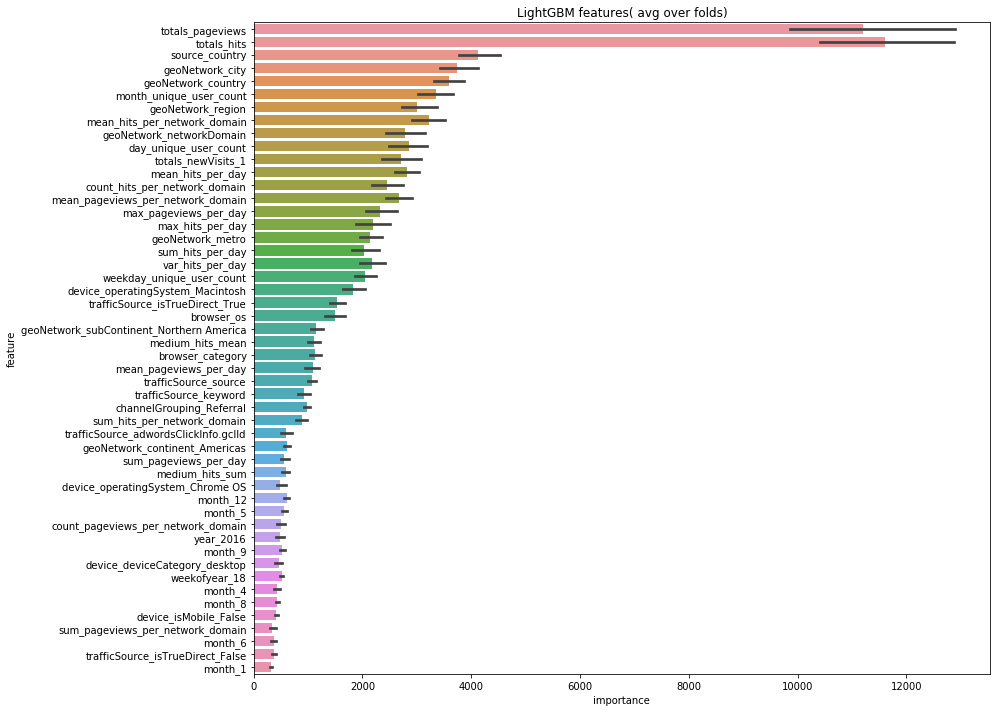

In [46]:
# Stratified Sampling
FOLDs= StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
oof_lgb = np.zeros(len(g_train_df))
predictions_lgb = np.zeros(len(g_test_df))
#print(list(X.columns))                          
features_lgb = list(X.columns)
feature_importance_df_lgb = pd.DataFrame()
                           
for fold_, (trn_idx,val_idx) in enumerate(FOLDs.split(X,y_categorized)):
    trn_data = lgb.Dataset(X.iloc[trn_idx],label=y_log.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx],label=y_log.iloc[val_idx])
    num_round=2000
    clf = lgb.train(lgb_params1,trn_data,num_round,valid_sets=[trn_data,val_data],verbose_eval=1000,early_stopping_rounds=100)
    oof_lgb[val_idx] = clf.predict(X.iloc[val_idx],num_iteration=clf.best_iteration)
    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb,fold_importance_df_lgb],axis=0)
    predictions_lgb += clf.predict(X_test,num_iteration=clf.best_iteration) / FOLDs.n_splits
    
    
cols = feature_importance_df_lgb[["feature","importance"]].groupby("feature").mean().sort_values(by="importance",ascending=False)[:50].index
best_features_lgb = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]
plt.figure(figsize=(14,10))
sns.barplot(x="importance",y="feature",data=best_features_lgb.sort_values(by="importance",ascending=False))
plt.title('LightGBM features( avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importancers.png')
x = []
for i in oof_lgb:
    if i<0:
        x.append(0.0)
    else:
        x.append(i)
cv_lgb = mean_squared_error(x,y_log)**0.5
cv_lgb = str(cv_lgb)
cv_lgb = cv_lgb[:10]
pd.DataFrame({'preds':x}).to_csv('lgb_oof_'+cv_lgb + '.csv',index=False)
print("CV_LGB:",cv_lgb)

In [47]:
sub_df = g_test_df[['fullVisitorId']].copy()
predictions_lgb[predictions_lgb<0] = 0
sub_df['PredictedLogRevenue'] = np.expm1(predictions_lgb)
print(sub_df.head(n=5))
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
print("*********")
print(sub_df.head(n=5))
sub_df.columns = ['fullVisitorId',"PredictedLogRevenue"]

sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("submission.csv",index=False)

         fullVisitorId  PredictedLogRevenue
0  6167871330617112363             0.001687
1  0643697640977915618             0.000000
2  6059383810968229466             0.006811
3  2376720078563423631             0.000000
4  2314544520795440038             0.000000
*********
         fullVisitorId  PredictedLogRevenue
0  0000000259678714014             0.098699
1  0000049363351866189             0.001256
2  0000053049821714864             0.000088
3  0000059488412965267             0.003936
4  0000085840370633780             0.002040
